In [363]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.morphology as morph

In [364]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [365]:
prueba1 = cv2.imread('database/2_gt.pgm', cv2.IMREAD_UNCHANGED)

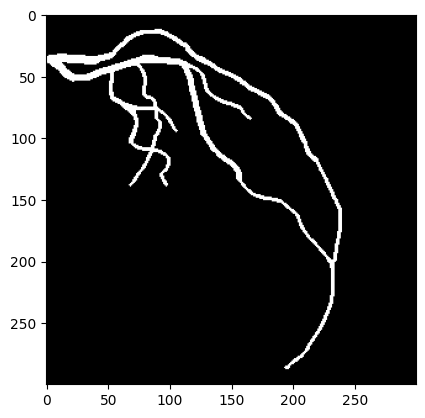

In [366]:
plot_image(prueba1)

In [367]:
def esqueletizar(imagen):
    return morph.skeletonize(imagen).astype(np.uint8)

In [368]:
def closing(imagen, kernel):
    return morph.closing(imagen, kernel)

In [369]:
def opening(imagen, kernel):
    return morph.opening(imagen, kernel)

In [370]:
def erosion(imagen, kernel):
    return morph.erosion(imagen, kernel)

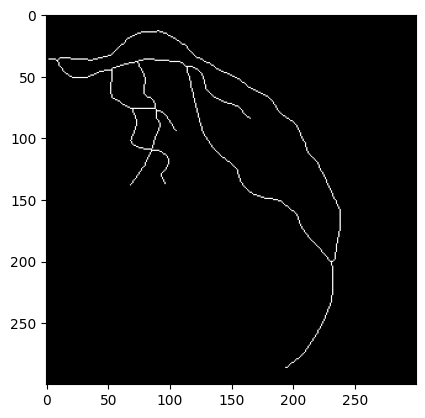

In [371]:
esqueleto = esqueletizar(prueba1)
plot_image(esqueleto)

In [372]:
graph = {}

In [373]:
class Node(object):
    x = 0
    y = 0

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def get_position(self):
        return (self.x, self.y)

In [374]:
def check_neighbors(x, y, image):
    neighbors = []
    down = False
    up = False
    right = False
    left = False
    # left 
    if x > 0 and image[x-1, y] == 1:
        neighbors.append((x-1, y))
        left = True
    # right
    if x < image.shape[0] - 1 and image[x+1, y] == 1:
        neighbors.append((x+1, y))
        right = True
    # up
    if y > 0 and image[x, y-1] == 1:
        neighbors.append((x, y-1))
        up = True
    # down
    if y < image.shape[1] - 1 and image[x, y+1] == 1:
        neighbors.append((x, y+1))
        down = True
    # upper left
    if x > 0 and y > 0 and image[x-1, y-1] == 1 and not (up or left):
        neighbors.append((x-1, y-1))
    # lower left
    if x > 0 and y < image.shape[1] - 1 and image[x-1, y+1] == 1 and not (down or left):
        neighbors.append((x-1, y+1))
    # upper right
    if x < image.shape[0] - 1 and y > 0 and image[x+1, y-1] == 1 and not (up or right):
        neighbors.append((x+1, y-1))
    # lower right
    if x < image.shape[0] - 1 and y < image.shape[1] - 1 and image[x+1, y+1] == 1 and not (down or right):
        neighbors.append((x+1, y+1))
    return neighbors

In [375]:
def construct_graph(imagen):
    imagen = imagen.copy()
    bifurcation = []
    trifurcation = []
    end_points = []
    intemediate = []
    cont = 0
    mod = 45
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if imagen[i][j] == 1:
                node = Node()
                node.set_position(i, j)
                graph[(i, j)] = node
                neighbors = check_neighbors(i, j, imagen)
                if len(neighbors) == 3:
                    bifurcation.append((i, j))
                if len(neighbors) == 4:
                    trifurcation.append((i, j))
                if len(neighbors) == 1:
                    end_points.append((i, j))
                if len(neighbors) == 2:
                    if cont % mod == 0:
                        intemediate.append((i, j))
                cont += 1 
    return graph, bifurcation, trifurcation, end_points, intemediate            

In [376]:
_, bifurcation, trifurcation, end_points, intermediate = construct_graph(esqueleto)

# Convertir arrays de NumPy a listas
bifurcation = np.unique(bifurcation, axis=0).tolist()
trifurcation = np.unique(trifurcation, axis=0).tolist()
end_points = np.unique(end_points, axis=0).tolist()

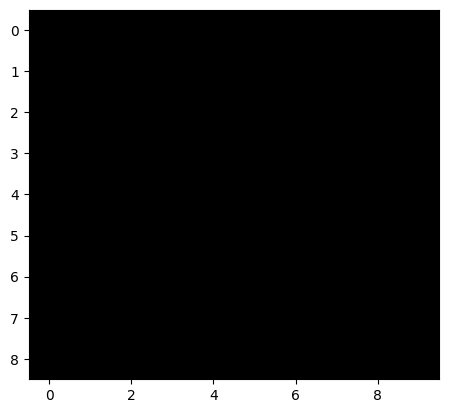

In [377]:
# temp = esqueleto[28:35, 160:170]
# temp = esqueleto[28:35, 160:170]
temp = esqueleto[41:50, 220:230]
# print(temp)
plot_image(temp)

In [378]:
def join_points(window_len,array):
    new_array = []
    elimimnar = []
    for element in array:
        matriz = [[0] * window_len for _ in range(window_len)]
        x, y = element
        for i in range(window_len):
            for j in range(window_len):
                matriz[i][j] = [x - window_len//2 + i,y - window_len//2 + j]
        for fila in matriz:
            for vecino in fila:
                if vecino in array and vecino != element:
                    avg = [(vecino[0] + x)//2, (vecino[1] + y)//2]
                    array.remove(vecino)
                    elimimnar.append(vecino)
                    if (x, y) not in elimimnar:
                        elimimnar.append(element)
                    new_array.append(avg)
                    
    for element in elimimnar:
        if element in array:
            array.remove(element)
            
    return array,new_array


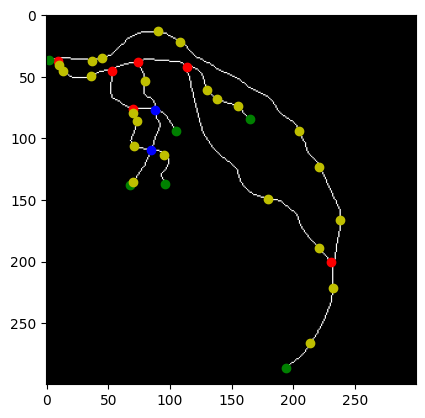

In [379]:
cuatrifurcation = []
ventana = 10
plt.imshow(esqueleto, cmap='gray')
bifurcation, new_trifurcation = join_points(ventana,bifurcation)
if len(new_trifurcation) > 0:
    if len(trifurcation) > 1:
        trifurcation.append(new_trifurcation)
    else:
        trifurcation.extend(new_trifurcation)


trifurcation, new_cuatrifurcation = join_points(ventana,trifurcation)
if len(new_cuatrifurcation) > 0:
    if len(cuatrifurcation) > 1:
        cuatrifurcation.append(new_cuatrifurcation)
    else:
        cuatrifurcation.extend(new_cuatrifurcation)

x = [coord[1] for coord in bifurcation]
y = [coord[0] for coord in bifurcation]
plt.plot(x, y, 'ro')

x2 = [coord[1] for coord in trifurcation]
y2 = [coord[0] for coord in trifurcation]
plt.plot(x2, y2, 'bo')

x3 = [coord[1] for coord in end_points]
y3 = [coord[0] for coord in end_points]
plt.plot(x3, y3, 'go')

x4 = [coord[1] for coord in intermediate]
y4 = [coord[0] for coord in intermediate]
plt.plot(x4, y4, 'yo')



plt.show()

In [380]:
result = bifurcation + trifurcation + end_points + intermediate

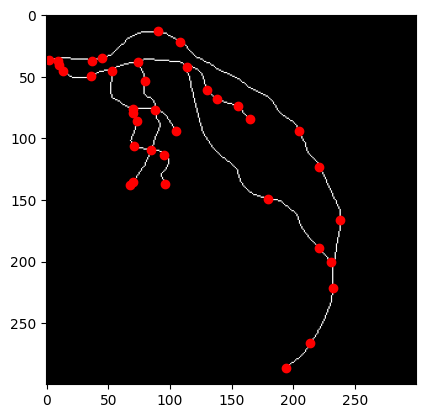

In [381]:
x = [coord[1] for coord in result]
y = [coord[0] for coord in result]
plt.plot(x, y, 'ro')
plt.imshow(esqueleto, cmap='gray')
plt.show()

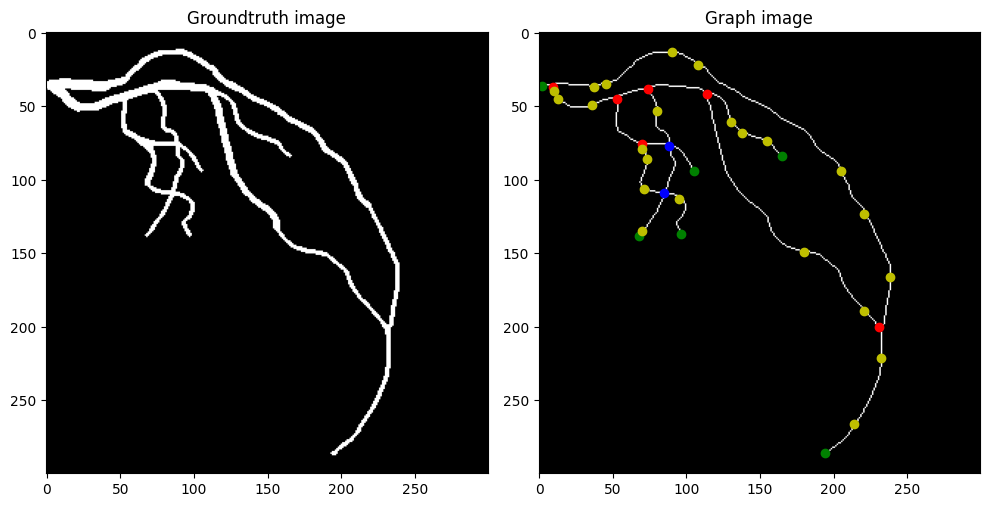

In [390]:
def Generate_data(ruta):
    imagen_groundtruth = cv2.imread(ruta, cv2.IMREAD_UNCHANGED)
    esqueleto = esqueletizar(imagen_groundtruth)
    
    plt.figure(figsize=(10, 5))

    # Subgráfico 1 (1 fila, 2 columnas, primer subgráfico)
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_groundtruth, cmap='gray')
    plt.title('Groundtruth image')
    
    _, bifurcation, trifurcation, end_points, intermediate = construct_graph(esqueleto)

    # Convertir arrays de NumPy a listas
    bifurcation = np.unique(bifurcation, axis=0).tolist()
    trifurcation = np.unique(trifurcation, axis=0).tolist()
    end_points = np.unique(end_points, axis=0).tolist()
    
    cuatrifurcation = []
    ventana = 10
    bifurcation, new_trifurcation = join_points(ventana,bifurcation)
    if len(new_trifurcation) > 0:
        if len(trifurcation) > 1:
            trifurcation.append(new_trifurcation)
        else:
            trifurcation.extend(new_trifurcation)


    trifurcation, new_cuatrifurcation = join_points(ventana,trifurcation)
    if len(new_cuatrifurcation) > 0:
        if len(cuatrifurcation) > 1:
            cuatrifurcation.append(new_cuatrifurcation)
        else:
            cuatrifurcation.extend(new_cuatrifurcation)

    plt.subplot(1, 2, 2)
    plt.imshow(esqueleto, cmap='gray')
    plt.title('Graph image')

    x = [coord[1] for coord in bifurcation]
    y = [coord[0] for coord in bifurcation]
    plt.plot(x, y, 'ro')

    x2 = [coord[1] for coord in trifurcation]
    y2 = [coord[0] for coord in trifurcation]
    plt.plot(x2, y2, 'bo')

    x3 = [coord[1] for coord in end_points]
    y3 = [coord[0] for coord in end_points]
    plt.plot(x3, y3, 'go')

    x4 = [coord[1] for coord in intermediate]
    y4 = [coord[0] for coord in intermediate]
    plt.plot(x4, y4, 'yo')


    plt.tight_layout()

    # Guardar la figura en un archivo (por ejemplo, PNG)
    plt.savefig('Imagenes_resultados/'+ruta[9:]+'.png')
    plt.show()
    

Generate_data('database/2_gt.pgm')
    